In [6]:
import numpy as np 
import tensorflow as tf
import pandas as pd
from tqdm import tqdm
import os
from cv2 import imread, createCLAHE 
import cv2
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import keras
keras.__version__
#print(tf.__version__)


'2.3.1'

In [2]:
images=np.load('D:/aminur/jsrt_dataset/img_crop_final_inverted.npy')
mask=np.load('D:/aminur/jsrt_dataset/jsrt_mask_heart.npy')
images=images
mask=mask
print(mask.max(), mask.min(),images.max(),images.min())
print(images.shape,mask.shape)

255.0 0.0 255.0 0.0
(247, 256, 256, 1) (247, 256, 256, 1)


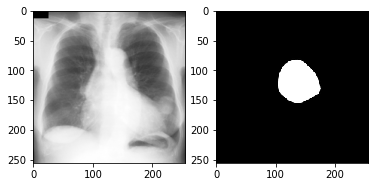

In [3]:
im = images.reshape((247, 256,256))
ma = mask.reshape((247, 256,256))
fig = plt.figure()
ax1 = fig.add_subplot(121)
# Bilinear interpolation - this will look blurry
ax1.imshow(im[1], interpolation='bilinear', cmap=cm.Greys_r)

ax2 = fig.add_subplot(122)
# 'nearest' interpolation - faithful but blocky
ax2.imshow(ma[1], interpolation='nearest', cmap=cm.Greys_r)

plt.show()


In [4]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, LearningRateScheduler


def dice_coef(y_true, y_pred):
    y_true_f = keras.flatten(y_true)
    y_pred_f = keras.flatten(y_pred)
    intersection = keras.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (keras.sum(y_true_f) + keras.sum(y_pred_f) + 1)

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)
def unet(input_size=(256,256,1)):
    inputs = Input(input_size)
    
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)

    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    
    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    conv10 = Conv2D(1, (1, 1), activation='sigmoid')(conv9)

    return Model(inputs=[inputs], outputs=[conv10])

Using TensorFlow backend.


In [5]:
model = unet(input_size=(256,256,1))
#lr=1e-5
model.compile(optimizer=Adam(lr=1e-5), loss=dice_coef_loss,
                  metrics=[dice_coef, 'binary_accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 256, 256, 32) 320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 128, 128, 32) 0           conv2d_2[0][0]                   
____________________________________________________________________________________________

In [6]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau
weight_path="{}_weights.best.hdf5".format('cxr_reg')

checkpoint = ModelCheckpoint('model_Unet_jsrt_heart_Xray_6.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

reduceLROnPlat = ReduceLROnPlateau(monitor='val_loss', factor=0.5, 
                                   patience=5, 
                                   verbose=1, mode='min', epsilon=0.0001, cooldown=2, min_lr=1e-6)
early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=15) # probably needs to be more patient, but kaggle time is limited
callbacks_list = [checkpoint,early, reduceLROnPlat]

D:\Anaconda3\envs\deep\lib\site-packages\keras\callbacks\callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


In [7]:
from IPython.display import clear_output
from keras.optimizers import Adam 
from sklearn.model_selection import train_test_split
#lr=2e-4
model.compile(optimizer=Adam(lr=1e-5), 
              loss=[dice_coef_loss], 
           metrics = [dice_coef, 'binary_accuracy'])

train_vol, validation_vol, train_seg, validation_seg = train_test_split((images-127.0)/127.0, 
                                                            (mask>127).astype(np.float32), 
                                                            test_size = 0.1,random_state = 2018)

#train_vol, test_vol, train_seg, test_seg = train_test_split(train_vol,train_seg, 
 #                                                           test_size = 0.1, 
  #                                                          random_state = 2018)

loss_history = model.fit(x = train_vol,
                       y = train_seg,
                         batch_size = 16,
                  epochs = 400,
                  validation_data =(validation_vol,validation_seg) ,
                  callbacks=callbacks_list)


#clear_output()

Train on 222 samples, validate on 25 samples
Epoch 1/400
222/222 [==============================] - 10s 46ms/step - loss: -0.0931 - dice_coef: 0.0931 - binary_accuracy: 0.2566 - val_loss: -0.0941 - val_dice_coef: 0.0931 - val_binary_accuracy: 0.3489

Epoch 00001: val_loss improved from inf to -0.09411, saving model to model_Unet_jsrt_heart_Xray_6.h5
Epoch 2/400
222/222 [==============================] - 4s 17ms/step - loss: -0.0935 - dice_coef: 0.0935 - binary_accuracy: 0.3967 - val_loss: -0.0945 - val_dice_coef: 0.0935 - val_binary_accuracy: 0.4216

Epoch 00002: val_loss improved from -0.09411 to -0.09449, saving model to model_Unet_jsrt_heart_Xray_6.h5
Epoch 3/400
222/222 [==============================] - 4s 18ms/step - loss: -0.0939 - dice_coef: 0.0938 - binary_accuracy: 0.4271 - val_loss: -0.0949 - val_dice_coef: 0.0939 - val_binary_accuracy: 0.4251

Epoch 00003: val_loss improved from -0.09449 to -0.09491, saving model to model_Unet_jsrt_heart_Xray_6.h5
Epoch 4/400
222/222 [=====

222/222 [==============================] - 4s 16ms/step - loss: -0.8313 - dice_coef: 0.8313 - binary_accuracy: 0.9825 - val_loss: -0.8507 - val_dice_coef: 0.8455 - val_binary_accuracy: 0.9849

Epoch 00056: val_loss did not improve from -0.85180
Epoch 57/400
222/222 [==============================] - 4s 16ms/step - loss: -0.8318 - dice_coef: 0.8318 - binary_accuracy: 0.9826 - val_loss: -0.8497 - val_dice_coef: 0.8435 - val_binary_accuracy: 0.9841

Epoch 00057: val_loss did not improve from -0.85180
Epoch 58/400
222/222 [==============================] - 4s 16ms/step - loss: -0.8336 - dice_coef: 0.8337 - binary_accuracy: 0.9829 - val_loss: -0.8491 - val_dice_coef: 0.8418 - val_binary_accuracy: 0.9835

Epoch 00058: val_loss did not improve from -0.85180
Epoch 59/400
222/222 [==============================] - 4s 16ms/step - loss: -0.8332 - dice_coef: 0.8334 - binary_accuracy: 0.9828 - val_loss: -0.8532 - val_dice_coef: 0.8464 - val_binary_accuracy: 0.9842

Epoch 00059: val_loss improved fr


Epoch 00114: val_loss did not improve from -0.88172
Epoch 115/400
222/222 [==============================] - 4s 16ms/step - loss: -0.8657 - dice_coef: 0.8657 - binary_accuracy: 0.9863 - val_loss: -0.8816 - val_dice_coef: 0.8755 - val_binary_accuracy: 0.9877

Epoch 00115: val_loss did not improve from -0.88172
Epoch 116/400
222/222 [==============================] - 4s 16ms/step - loss: -0.8646 - dice_coef: 0.8644 - binary_accuracy: 0.9861 - val_loss: -0.8810 - val_dice_coef: 0.8747 - val_binary_accuracy: 0.9874

Epoch 00116: val_loss did not improve from -0.88172

Epoch 00116: ReduceLROnPlateau reducing learning rate to 1.249999968422344e-06.
Epoch 117/400
222/222 [==============================] - 4s 16ms/step - loss: -0.8654 - dice_coef: 0.8654 - binary_accuracy: 0.9862 - val_loss: -0.8820 - val_dice_coef: 0.8762 - val_binary_accuracy: 0.9879

Epoch 00117: val_loss improved from -0.88172 to -0.88198, saving model to model_Unet_jsrt_heart_Xray_6.h5
Epoch 118/400
222/222 [============


Epoch 00144: val_loss did not improve from -0.88309
Epoch 145/400
222/222 [==============================] - 4s 16ms/step - loss: -0.8661 - dice_coef: 0.8661 - binary_accuracy: 0.9863 - val_loss: -0.8834 - val_dice_coef: 0.8773 - val_binary_accuracy: 0.9879

Epoch 00145: val_loss improved from -0.88309 to -0.88335, saving model to model_Unet_jsrt_heart_Xray_6.h5
Epoch 146/400
222/222 [==============================] - 4s 16ms/step - loss: -0.8663 - dice_coef: 0.8664 - binary_accuracy: 0.9863 - val_loss: -0.8829 - val_dice_coef: 0.8770 - val_binary_accuracy: 0.9879

Epoch 00146: val_loss did not improve from -0.88335
Epoch 147/400
222/222 [==============================] - 4s 16ms/step - loss: -0.8665 - dice_coef: 0.8665 - binary_accuracy: 0.9864 - val_loss: -0.8797 - val_dice_coef: 0.8735 - val_binary_accuracy: 0.9872

Epoch 00147: val_loss did not improve from -0.88335
Epoch 148/400
222/222 [==============================] - 4s 16ms/step - loss: -0.8657 - dice_coef: 0.8657 - binary_a

222/222 [==============================] - 4s 16ms/step - loss: -0.8672 - dice_coef: 0.8672 - binary_accuracy: 0.9865 - val_loss: -0.8818 - val_dice_coef: 0.8757 - val_binary_accuracy: 0.9875

Epoch 00175: val_loss did not improve from -0.88396
Epoch 176/400
222/222 [==============================] - 4s 16ms/step - loss: -0.8676 - dice_coef: 0.8674 - binary_accuracy: 0.9865 - val_loss: -0.8838 - val_dice_coef: 0.8777 - val_binary_accuracy: 0.9879

Epoch 00176: val_loss did not improve from -0.88396
Epoch 177/400
222/222 [==============================] - 4s 16ms/step - loss: -0.8679 - dice_coef: 0.8680 - binary_accuracy: 0.9865 - val_loss: -0.8839 - val_dice_coef: 0.8779 - val_binary_accuracy: 0.9879

Epoch 00177: val_loss did not improve from -0.88396
Epoch 178/400
222/222 [==============================] - 4s 16ms/step - loss: -0.8679 - dice_coef: 0.8681 - binary_accuracy: 0.9864 - val_loss: -0.8842 - val_dice_coef: 0.8782 - val_binary_accuracy: 0.9880

Epoch 00178: val_loss improved

222/222 [==============================] - 4s 16ms/step - loss: -0.8683 - dice_coef: 0.8684 - binary_accuracy: 0.9865 - val_loss: -0.8836 - val_dice_coef: 0.8778 - val_binary_accuracy: 0.9882

Epoch 00206: val_loss did not improve from -0.88474
Epoch 207/400
222/222 [==============================] - 4s 16ms/step - loss: -0.8671 - dice_coef: 0.8672 - binary_accuracy: 0.9864 - val_loss: -0.8847 - val_dice_coef: 0.8788 - val_binary_accuracy: 0.9882

Epoch 00207: val_loss did not improve from -0.88474
Epoch 208/400
222/222 [==============================] - 4s 16ms/step - loss: -0.8677 - dice_coef: 0.8679 - binary_accuracy: 0.9865 - val_loss: -0.8849 - val_dice_coef: 0.8788 - val_binary_accuracy: 0.9880

Epoch 00208: val_loss improved from -0.88474 to -0.88485, saving model to model_Unet_jsrt_heart_Xray_6.h5
Epoch 209/400
222/222 [==============================] - 4s 16ms/step - loss: -0.8689 - dice_coef: 0.8686 - binary_accuracy: 0.9866 - val_loss: -0.8838 - val_dice_coef: 0.8777 - val_b

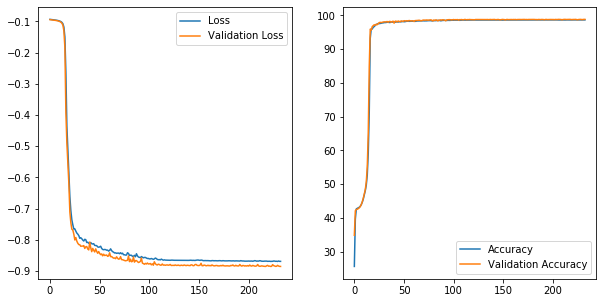

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (10, 5))
ax1.plot(loss_history.history['loss'], '-', label = 'Loss')
ax1.plot(loss_history.history['val_loss'], '-', label = 'Validation Loss')
ax1.legend()

ax2.plot(100*np.array(loss_history.history['binary_accuracy']), '-', 
         label = 'Accuracy')
ax2.plot(100*np.array(loss_history.history['val_binary_accuracy']), '-',
         label = 'Validation Accuracy')
ax2.legend()

In [9]:
model.load_weights('model_Unet_jsrt_heart_Xray_6.h5')
#print (validation_vol.shape,type(validation_vol))

max X:  255.0
min X:  0.0
1018/1018 [==============================] - 10s 10ms/step
max predict:  0.00082227704  min predict:  0.0


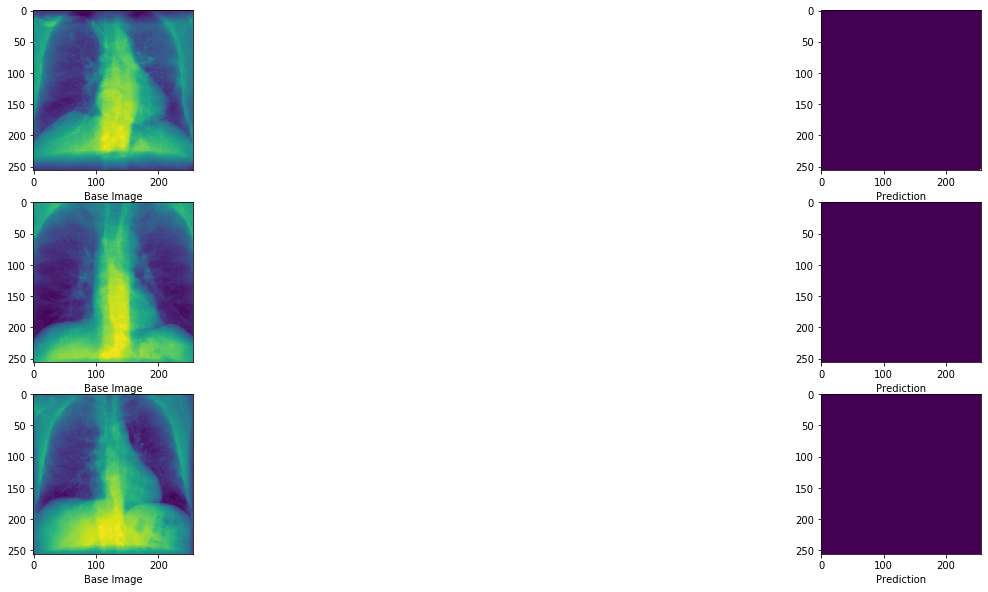

In [10]:
X=np.load('D:/aminur/data/X2CT.npy')
max_value = float(X.max())
print("max X: ",max_value)
print("min X: ", X.min())
pred_candidates = np.random.randint(1,X.shape[0],10)
preds = model.predict(X,batch_size=1,verbose=1)
#preds=preds*255.0
print("max predict: ",preds.max()," min predict: ",preds.min())
np.save('D:/aminur/jsrt_dataset/result_X2CT_jsrt_heart6_(1e-5).npy',preds)

plt.figure(figsize=(20,10))

for i in range(0,9,3):
    plt.subplot(3,3,i+1)
    
    plt.imshow(np.squeeze(X[pred_candidates[i]]))
    plt.xlabel("Base Image")
    
    
    plt.subplot(3,3,i+3)
    plt.imshow(np.squeeze(preds[pred_candidates[i]]))
    plt.xlabel("Prediction")

50/50 [==============================] - 0s 10ms/step


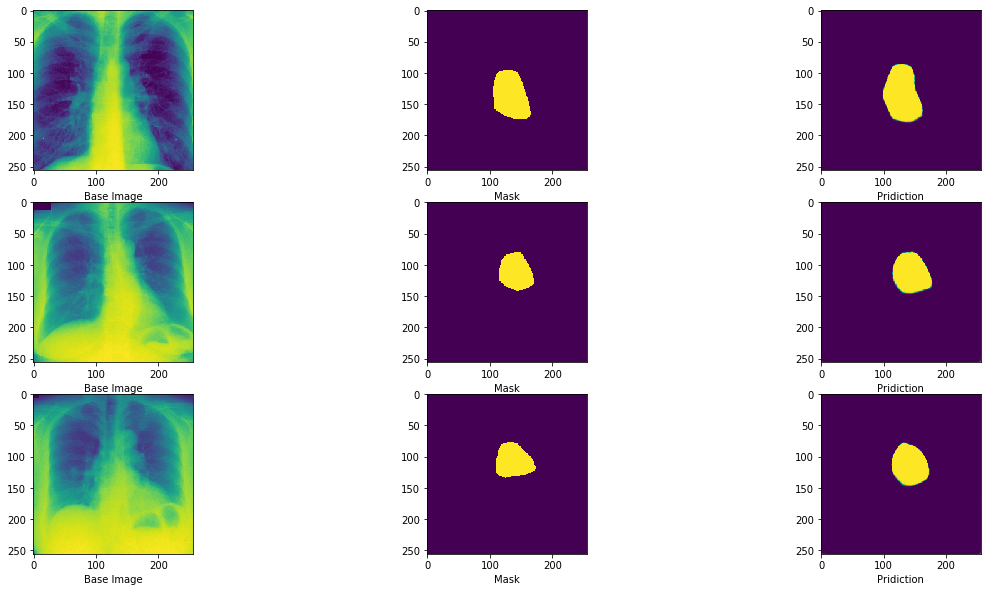

In [12]:
pred_candidates = np.random.randint(1,validation_vol.shape[0],10)
preds = model.predict(validation_vol,batch_size=1,verbose=1)

plt.figure(figsize=(20,10))

for i in range(0,9,3):
    plt.subplot(3,3,i+1)
    
    plt.imshow(np.squeeze(validation_vol[pred_candidates[i]]))
    plt.xlabel("Base Image")
    
    
    plt.subplot(3,3,i+2)
    plt.imshow(np.squeeze(validation_seg[pred_candidates[i]]))
    plt.xlabel("Mask")
    
    plt.subplot(3,3,i+3)
    plt.imshow(np.squeeze(preds[pred_candidates[i]]))
    plt.xlabel("Pridiction")